### Reference: https://github.com/jocicmarko/ultrasound-nerve-segmentation

In [1]:
import tensorflow
import keras

Using TensorFlow backend.


In [2]:
%matplotlib inline
import cv2
import os
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import h5py
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### change the resolution to 128 * 128
- result : 0.57521, will not use it right now	

### basic information

In [3]:
K.set_image_dim_ordering('th')
img_rows = 128
img_cols = 160
image_rows = 420
image_cols = 580
smooth = 1.

### data augmentation
### code from https://www.kaggle.com/bguberfain/ultrasound-nerve-segmentation/elastic-transform-for-data-augmentation/comments

### generate elastic image

In [4]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [5]:
data_scource = 'origin_data/'
image_rows = 420
image_cols = 580

In [28]:
## need to resize image first
def create_elastic_train_data(img_rows, img_cols):
    train_data_path = os.path.join(data_scource, 'train/')
    images = os.listdir(train_data_path)
    total = len(images) / 2

    imgs = np.ndarray((total, 1, img_rows, img_cols), dtype=np.uint8)
    imgs_mask = np.ndarray((total, 1, img_rows, img_cols), dtype=np.uint8)

    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    for image_name in images:
        if 'mask' in image_name:
            continue
        image_mask_name = image_name.split('.')[0] + '_mask.tif'
        img = cv2.imread(os.path.join(train_data_path, image_name), cv2.IMREAD_GRAYSCALE)
        img_mask = cv2.imread(os.path.join(train_data_path, image_mask_name), cv2.IMREAD_GRAYSCALE)
        
        img =  cv2.resize(img, (img_cols, img_rows))
        img_mask = cv2.resize(img_mask, (img_cols, img_rows))

        
        im_merge = np.concatenate((img[...,None], img_mask[...,None]), axis=2)
        
        im_merge_t = elastic_transform(im_merge, 
                                       im_merge.shape[1] * 2, im_merge.shape[1] * 0.08, im_merge.shape[1] * 0.08)

        # Split image and mask
        img = im_merge_t[...,0]
        img_mask = im_merge_t[...,1]
        
        img = np.array([img])
        img_mask = np.array([img_mask])

        imgs[i] = img
        imgs_mask[i] = img_mask

        if i % 1000 == 0:
            print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save('imgs_train_t.npy', imgs)
    np.save('imgs_mask_train_t.npy', imgs_mask)
    print('Saving to .npy files done.')

In [29]:
create_elastic_train_data(img_rows, img_cols)

------------------------------
Creating training images...
------------------------------
Done: 0/5635 images
Done: 1000/5635 images
Done: 2000/5635 images
Done: 3000/5635 images
Done: 4000/5635 images
Done: 5000/5635 images
Loading done.
Saving to .npy files done.


### finish generate data augmentation

In [6]:
def load_train_elastic_data():
    imgs_train_t = np.load('imgs_train_t.npy')
    imgs_mask_train_t = np.load('imgs_mask_train_t.npy')
    return imgs_train_t, imgs_mask_train_t

In [32]:
imgs_train_t, imgs_mask_train_t = load_train_elastic_data()

In [41]:
imgs_train_t.shape

(5635, 1, 128, 160)

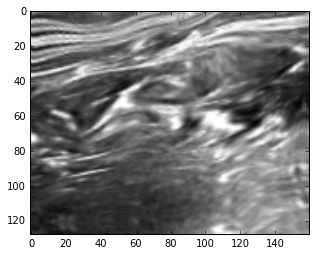

In [39]:
plt.imshow(imgs_train_t[0,0],'gray')

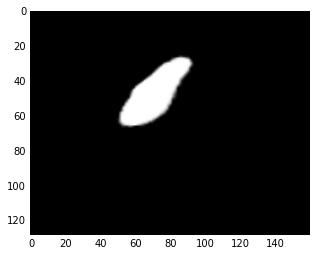

In [40]:
plt.imshow(imgs_mask_train_t[0,0],'gray')

In [7]:
def load_train_data():
    imgs_train = np.load('imgs_train.npy')
    imgs_mask_train = np.load('imgs_mask_train.npy')
    return imgs_train, imgs_mask_train

In [8]:
def load_test_data():
    imgs_test = np.load('imgs_test.npy')
    imgs_id = np.load('imgs_id_test.npy')
    return imgs_test, imgs_id

### loss function

In [9]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [10]:
def get_unet():
    inputs = Input((1, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)
    pool5 = MaxPooling2D(pool_size = (2, 2))(conv5)
    
    conv5_5 = Convolution2D(1024, 3, 3, activation = 'relu', border_mode = 'same')(pool5)
    conv5_5 = Convolution2D(512, 3, 3, activation = 'relu', border_mode = 'same')(conv5_5)
    
    up5_5 = merge([UpSampling2D(size = (2, 2))(conv5_5), conv5],mode = 'concat', concat_axis =1)
    conv6_5 = Convolution2D(512, 3, 3, activation = 'relu', border_mode = 'same')(up5_5)
    conv6_5 = Convolution2D(256, 3, 3, activation = 'relu', border_mode = 'same')(conv6_5)
    
    up6 = merge([UpSampling2D(size=(2, 2))(conv6_5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [11]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], imgs.shape[1], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i, 0] = cv2.resize(imgs[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    return imgs_p

In [16]:
def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data()
    imgs_train_t, imgs_mask_train_t = load_train_elastic_data()
    
    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)
    
    imgs_train_t = preprocess(imgs_train_t)
    imgs_mask_train_t = preprocess(imgs_mask_train_t)
    
    imgs_train = np.concatenate((imgs_train, imgs_train_t), axis = 0)
    imgs_mask_train = np.concatenate((imgs_mask_train, imgs_mask_train_t), axis = 0)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    model.fit(imgs_train, imgs_mask_train, batch_size=16, nb_epoch=20, verbose=1, shuffle=True,
              callbacks=[model_checkpoint])

    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test, imgs_id_test = load_test_data()
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('unet.hdf5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)

    print('-'*30)
    print('finish...')
    print('-'*30)

In [20]:
def prep(img):
    img = img.astype('float32')
    img = cv2.threshold(img, 0.5, 1., cv2.THRESH_BINARY)[1].astype(np.uint8)
    img = cv2.resize(img, (image_cols, image_rows))
    return img


def run_length_enc(label):
    from itertools import chain
    x = label.transpose().flatten()
    y = np.where(x > 0)[0]
    if len(y) < 10:  # consider as empty
        return ''
    z = np.where(np.diff(y) > 1)[0]
    start = np.insert(y[z+1], 0, y[0])
    end = np.append(y[z], y[-1])
    length = end - start
    res = [[s+1, l+1] for s, l in zip(list(start), list(length))]
    res = list(chain.from_iterable(res))
    return ' '.join([str(r) for r in res])


def submission():
    imgs_test, imgs_id_test = load_test_data()
    imgs_test = np.load('imgs_mask_test.npy')

    argsort = np.argsort(imgs_id_test)
    imgs_id_test = imgs_id_test[argsort]
    imgs_test = imgs_test[argsort]

    total = imgs_test.shape[0]
    ids = []
    rles = []
    for i in range(total):
        img = imgs_test[i, 0]
        img = prep(img)
        rle = run_length_enc(img)

        rles.append(rle)
        ids.append(imgs_id_test[i])

        if i % 1000 == 0:
            print('{}/{}'.format(i, total))

    first_row = 'img,pixels'
    file_name = 'submission5.csv'

    with open(file_name, 'w+') as f:
        f.write(first_row + '\n')
        for i in range(total):
            s = str(ids[i]) + ',' + rles[i]
            f.write(s + '\n')

In [14]:
imgs_test, imgs_id = load_test_data()

In [19]:
train_and_predict()

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Epoch 1/20
11270/11270 [==============================] - 504s - loss: -0.1810 - dice_coef: 0.1810   
Epoch 2/20
11270/11270 [==============================] - 497s - loss: -0.3897 - dice_coef: 0.3897   
Epoch 3/20
11270/11270 [==============================] - 496s - loss: -0.4754 - dice_coef: 0.4754   
Epoch 4/20
11270/11270 [==============================] - 498s - loss: -0.5147 - dice_coef: 0.5147   
Epoch 5/20
11270/11270 [==============================] - 497s - loss: -0.5401 - dice_coef: 0.5401   
Epoch 6/20
11270/11270 [==============================] - 497s - loss: -0.5595 - dice_coef: 0.5595   
Epoch 7/20
11270/11270 [==============================] - 497s - loss: -0.5724 - dice_coef: 0.5724   
Epoch 8/20


In [21]:
submission()

0/5508
1000/5508
2000/5508
3000/5508
4000/5508
5000/5508


### result 0.61191